In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn import random_projection
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.mixture import GaussianMixture

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features.pca import PCADecomposition


from scipy.io import arff

import matplotlib as mpl
import matplotlib.pyplot as plt

from time import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [2]:
##loading wine data ..
file = "wine.arff"
data = arff.loadarff(file)
df = pd.DataFrame(data[0])

features = ['fixed_acidity',  'pH', 'residual_sugar', 'volatile_acidity',  
'citric_acid',  'chlorides', 'free_sulfur_dioxide',  
'total_sulfur_dioxide',  'density',  'sulphates', 'alcohol']

training_score = 'training score'
cross_validation_score = 'cross validation score'
y_label = 'fl score'
y_axis = 'fl score'
random_state = 69


x_features = df[features]
y_predict = df.quality

x_train, x_test, y_train, y_test = train_test_split(x_features, y_predict, test_size=0.3, random_state=40)

num_of_comp = len(x_train.columns)

x_train_list = np.array(x_train.values.tolist())
y_train_list = np.array(y_train.values.tolist()).astype(int)

x_test_list = np.array(x_test.values.tolist())
y_test_list = np.array(y_test.values.tolist()).astype(int)


#####FEATURE REDUCTION######
pca = decomposition.PCA(n_components=6)
pca.fit(x_train_list)
x_train_pca = pca.transform(x_train_list)
x_test_pca = pca.transform(x_test_list)

ica = decomposition.FastICA(n_components=7)
ica.fit(x_train_list)
x_train_ica = ica.transform(x_train_list)
x_test_ica = ica.transform(x_test_list)

rp = random_projection.SparseRandomProjection(n_components=8)
rp.fit(x_train)
x_train_rp = rp.transform(x_train)
x_test_rp = rp.transform(x_test)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_train, y_train)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(x_train)

amount_of_features = X_new.shape[1]

####EXTRA one, using trees####

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=random_state)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


FFI = []
for f in range(amount_of_features):
    FFI.append(x_train.columns[indices[f]])


x_train_ffi = x_train[FFI]
x_test_ffi = x_test[FFI]


In [3]:


def gen_learning_curve(nn,x,y, title):
    train_sizes = [10, 100, 250, 400, 600, 894]
    
    train_sizes, train_scores, validation_scores = learning_curve(estimator = nn, X = x,y = y, train_sizes = train_sizes, cv = 5,scoring = 'f1')

    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    # print('Training scores:\n\n', train_scores)
    # print('\n', '-' * 70) # separator to make the output easy to read
    # print('\nValidation scores:\n\n', validation_scores)


    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = training_score)
    plt.plot(train_sizes, validation_scores_mean, label = cross_validation_score)
    plt.ylabel(y_label, fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for neural network: ' + title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(.0,1.1)
    plt.show()

Accuracy test set: 0.6833333333333333
{'0.0': {'precision': 0.6363636363636364, 'recall': 0.7064220183486238, 'f1-score': 0.6695652173913044, 'support': 218}, '1.0': {'precision': 0.7310924369747899, 'recall': 0.6641221374045801, 'f1-score': 0.6960000000000001, 'support': 262}, 'accuracy': 0.6833333333333333, 'macro avg': {'precision': 0.6837280366692131, 'recall': 0.6852720778766019, 'f1-score': 0.6827826086956522, 'support': 480}, 'weighted avg': {'precision': 0.688069773363891, 'recall': 0.6833333333333333, 'f1-score': 0.6839942028985507, 'support': 480}}
training time:  0.17046284675598145


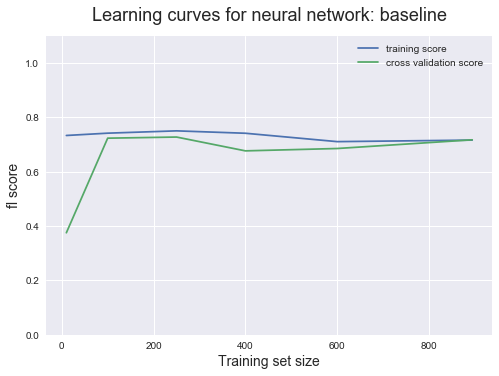

In [36]:
####BASELINE####
def run_nn(x, y, xtes, ytes, title):
    t0 = time()
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(7, 21), random_state=random_state, learning_rate='adaptive', max_iter=100000, n_iter_no_change=10000)
    clf.fit(x, y)
    t1 = time()

    #y_pred_val = clf.predict(x_val1)
    y_pred_test = clf.predict(xtes)
    
    m = metrics.classification_report(ytes, y_pred_test, output_dict = True)
    
    #print("Accuracy validation set:",metrics.accuracy_score(y_val1, y_pred_val))
    print("Accuracy test set:",metrics.accuracy_score(ytes, y_pred_test))
    print(m)
    print("training time: ", t1 - t0)

    ###### random_state = 9
    nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(7, 21),random_state=random_state ,learning_rate='adaptive', max_iter=100000, n_iter_no_change=10000)
    gen_learning_curve(nn, x, y, title)
    
def run_nn_rs(x, y, xtes, ytes, title, rs):
    t0 = time()
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(7, 21), random_state=rs, learning_rate='adaptive', max_iter=100000, n_iter_no_change=10000)
    clf.fit(x, y)
    t1 = time()

    #y_pred_val = clf.predict(x_val1)
    y_pred_test = clf.predict(xtes)
    
    m = metrics.classification_report(ytes, y_pred_test, output_dict = True)
    
    #print("Accuracy validation set:",metrics.accuracy_score(y_val1, y_pred_val))
    print("Accuracy test set:",metrics.accuracy_score(ytes, y_pred_test))
    print(m)
    print("training time: ", t1 - t0)

    ###### random_state = 9
    nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(7, 21),random_state=rs ,learning_rate='adaptive', max_iter=100000, n_iter_no_change=10000)
    gen_learning_curve(nn, x, y, title)
    

run_nn(x_train, y_train, x_test, y_test, 'baseline')



baseline ***************************************************************************************************
Accuracy test set: 0.6833333333333333
{'0.0': {'precision': 0.6363636363636364, 'recall': 0.7064220183486238, 'f1-score': 0.6695652173913044, 'support': 218}, '1.0': {'precision': 0.7310924369747899, 'recall': 0.6641221374045801, 'f1-score': 0.6960000000000001, 'support': 262}, 'accuracy': 0.6833333333333333, 'macro avg': {'precision': 0.6837280366692131, 'recall': 0.6852720778766019, 'f1-score': 0.6827826086956522, 'support': 480}, 'weighted avg': {'precision': 0.688069773363891, 'recall': 0.6833333333333333, 'f1-score': 0.6839942028985507, 'support': 480}}
training time:  0.1565709114074707


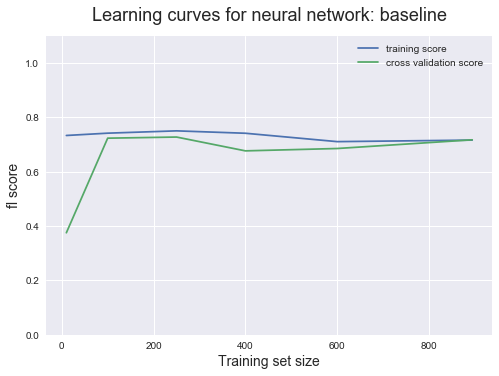

pca ***************************************************************************************************
Accuracy test set: 0.7354166666666667
{'0.0': {'precision': 0.7077625570776256, 'recall': 0.7110091743119266, 'f1-score': 0.7093821510297483, 'support': 218}, '1.0': {'precision': 0.7586206896551724, 'recall': 0.7557251908396947, 'f1-score': 0.7571701720841301, 'support': 262}, 'accuracy': 0.7354166666666667, 'macro avg': {'precision': 0.733191623366399, 'recall': 0.7333671825758106, 'f1-score': 0.7332761615569392, 'support': 480}, 'weighted avg': {'precision': 0.7355226211095366, 'recall': 0.7354166666666667, 'f1-score': 0.735466445855265, 'support': 480}}
training time:  1.9834980964660645


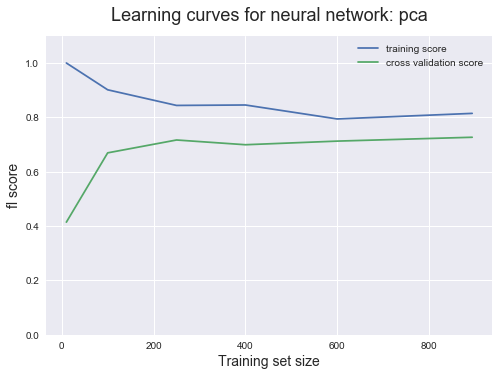

ica ***************************************************************************************************
Accuracy test set: 0.7583333333333333
{'0.0': {'precision': 0.7276785714285714, 'recall': 0.7477064220183486, 'f1-score': 0.7375565610859728, 'support': 218}, '1.0': {'precision': 0.78515625, 'recall': 0.767175572519084, 'f1-score': 0.7760617760617761, 'support': 262}, 'accuracy': 0.7583333333333333, 'macro avg': {'precision': 0.7564174107142857, 'recall': 0.7574409972687163, 'f1-score': 0.7568091685738745, 'support': 480}, 'weighted avg': {'precision': 0.7590518043154761, 'recall': 0.7583333333333333, 'f1-score': 0.7585739909269321, 'support': 480}}
training time:  0.2758502960205078


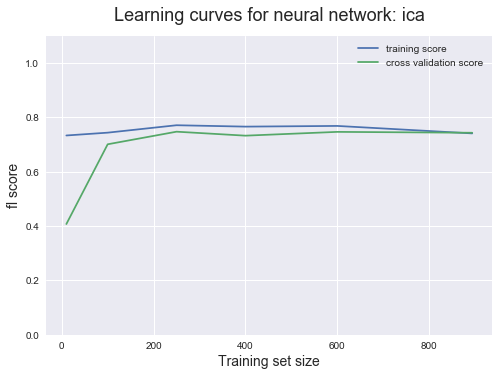

rp ***************************************************************************************************
Accuracy test set: 0.75
{'0.0': {'precision': 0.7378640776699029, 'recall': 0.6972477064220184, 'f1-score': 0.7169811320754718, 'support': 218}, '1.0': {'precision': 0.7591240875912408, 'recall': 0.7938931297709924, 'f1-score': 0.7761194029850745, 'support': 262}, 'accuracy': 0.75, 'macro avg': {'precision': 0.7484940826305719, 'recall': 0.7455704180965054, 'f1-score': 0.7465502675302731, 'support': 480}, 'weighted avg': {'precision': 0.7494684997519665, 'recall': 0.75, 'f1-score': 0.7492607716136299, 'support': 480}}
training time:  1.266552209854126


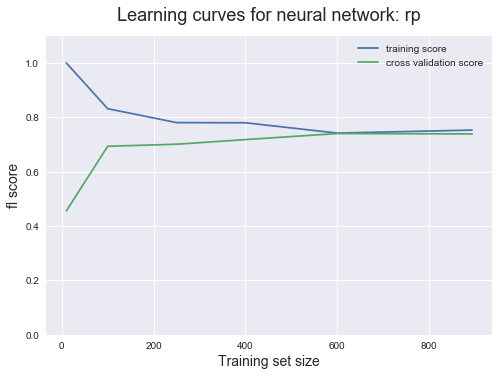

ffi ***************************************************************************************************
Accuracy test set: 0.7375
{'0.0': {'precision': 0.7277227722772277, 'recall': 0.6743119266055045, 'f1-score': 0.7, 'support': 218}, '1.0': {'precision': 0.7446043165467626, 'recall': 0.7900763358778626, 'f1-score': 0.7666666666666667, 'support': 262}, 'accuracy': 0.7375, 'macro avg': {'precision': 0.7361635444119952, 'recall': 0.7321941312416835, 'f1-score': 0.7333333333333334, 'support': 480}, 'weighted avg': {'precision': 0.736937281857682, 'recall': 0.7375, 'f1-score': 0.736388888888889, 'support': 480}}
training time:  0.0914146900177002


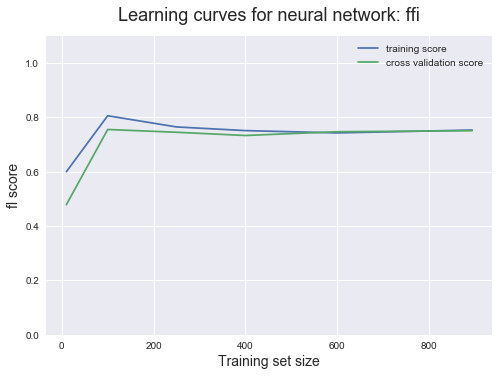

In [34]:
print("baseline","*"*99)
run_nn(x_train, y_train, x_test, y_test, 'baseline')
print("pca","*"*99)
run_nn(x_train_pca, y_train, x_test_pca, y_test, 'pca')
print("ica","*"*99)
run_nn(x_train_ica, y_train, x_test_ica, y_test, 'ica')
print("rp","*"*99)
run_nn(x_train_rp, y_train, x_test_rp, y_test, 'rp')
print("ffi","*"*99)
run_nn(x_train_ffi, y_train, x_test_ffi, y_test, 'ffi')

In [16]:
###ADDING kmeans cluster to original data
#labels_
x_train_kmeans = x_train.copy(deep=True)
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=30, random_state=random_state)
kmeans.fit(x_train)
x_train_kmeans['kmeans_cluster'] = kmeans.labels_

x_test_kmeans = x_test.copy()
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=30, random_state=random_state)
kmeans.fit(x_test)
x_test_kmeans['kmeans_cluster'] = kmeans.labels_



x_train_gm = x_train.copy()
gm = GaussianMixture(n_components=8,covariance_type='tied', max_iter=200, random_state=random_state)
gm.fit(x_train)
gm_labels = gm.predict(x_train)
x_train_gm['gm_cluster'] = gm_labels

x_test_gm = x_test.copy()
gm = GaussianMixture(n_components=8,covariance_type='tied', max_iter=200, random_state=random_state)
gm.fit(x_test)
gm_labels = gm.predict(x_test)
x_test_gm['gm_cluster'] = gm_labels



baseline ***************************************************************************************************
Accuracy test set: 0.7479166666666667
{'0.0': {'precision': 0.7235023041474654, 'recall': 0.7201834862385321, 'f1-score': 0.7218390804597701, 'support': 218}, '1.0': {'precision': 0.7680608365019012, 'recall': 0.7709923664122137, 'f1-score': 0.7695238095238095, 'support': 262}, 'accuracy': 0.7479166666666667, 'macro avg': {'precision': 0.7457815703246833, 'recall': 0.7455879263253729, 'f1-score': 0.7456814449917898, 'support': 480}, 'weighted avg': {'precision': 0.7478238363909283, 'recall': 0.7479166666666667, 'f1-score': 0.7478669950738916, 'support': 480}}
training time:  0.2636909484863281


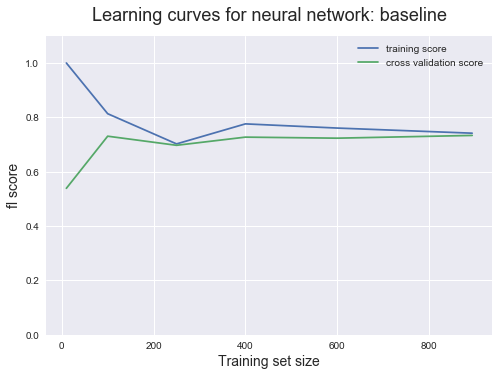

kmeans ***************************************************************************************************
Accuracy test set: 0.7541666666666667
{'0.0': {'precision': 0.7403846153846154, 'recall': 0.7064220183486238, 'f1-score': 0.7230046948356808, 'support': 218}, '1.0': {'precision': 0.7647058823529411, 'recall': 0.7938931297709924, 'f1-score': 0.7790262172284643, 'support': 262}, 'accuracy': 0.7541666666666667, 'macro avg': {'precision': 0.7525452488687783, 'recall': 0.7501575740598081, 'f1-score': 0.7510154560320725, 'support': 480}, 'weighted avg': {'precision': 0.7536599736048265, 'recall': 0.7541666666666667, 'f1-score': 0.7535831091417418, 'support': 480}}
training time:  2.0862529277801514


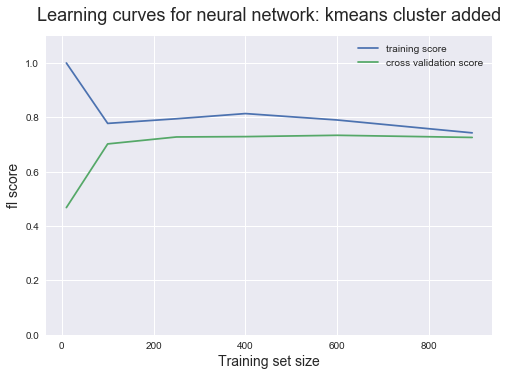

em ***************************************************************************************************
Accuracy test set: 0.74375
{'0.0': {'precision': 0.7317073170731707, 'recall': 0.6880733944954128, 'f1-score': 0.7092198581560284, 'support': 218}, '1.0': {'precision': 0.7527272727272727, 'recall': 0.7900763358778626, 'f1-score': 0.7709497206703911, 'support': 262}, 'accuracy': 0.74375, 'macro avg': {'precision': 0.7422172949002217, 'recall': 0.7390748651866377, 'f1-score': 0.7400847894132098, 'support': 480}, 'weighted avg': {'precision': 0.7431807095343681, 'recall': 0.74375, 'f1-score': 0.7429140747784513, 'support': 480}}
training time:  1.5954439640045166


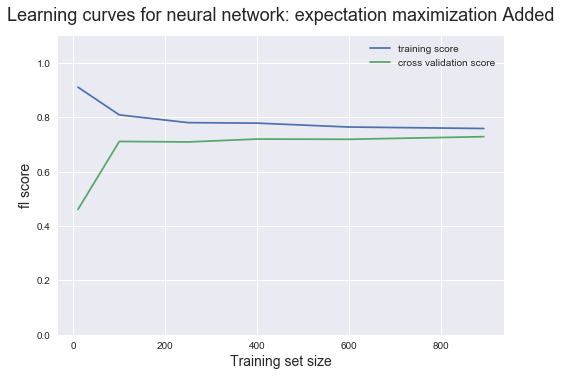

In [52]:
rand = 37
print("baseline","*"*99)
run_nn_rs(x_train, y_train, x_test, y_test, 'baseline', rand)
print("kmeans","*"*99)
run_nn_rs(x_train_kmeans, y_train, x_test_kmeans, y_test, 'kmeans cluster added', rand)
print("em","*"*99)
run_nn_rs(x_train_gm, y_train, x_test_gm, y_test, 'expectation maximization Added', rand)

    